In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload

from icedef import drift, metocean, simulator, plot, iceberg, test_case, timesteppers
from icedef import statoil_arcticnet_data as sd

plt.rcParams['figure.figsize'] = (6, 6)
plot_dir = './plots/'
data_dir = './data/'

In [287]:
tc = test_case.TestCaseB()
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args)
sim.results.add(tc.ref_times, tc.ref_lats.values, tc.ref_lons.values, label='reference')
sim.run_simulation(label='default')

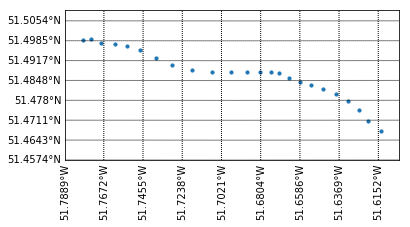

In [288]:
tc.plot_track(sizes=10)

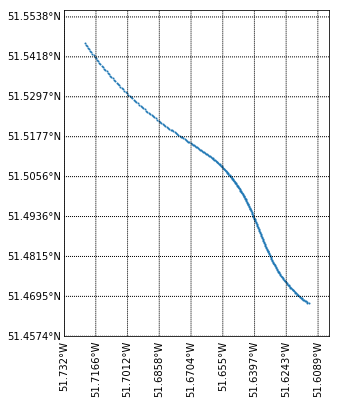

In [289]:
fig, ax = sim.results.plot(['default'])

# Optimizing Ca and Cw

### Scipy minimize

In [290]:
run_optimization = False

if not run_optimization:
    optimization_result = type('dummy', (object,), {})()
    optimization_result.x = np.array([9.15857407, 1.94167373])
    
else:
    
    keys = ['Ca', 'Cw']
    x0 = [1, 1]
    bounds = [[0.01, 15], [0.01, 15]]
    reference_vectors = [tc.ref_lats, tc.ref_lons]
    optimization_result = sim.run_optimization(keys, x0, bounds, reference_vectors)

optimization_result.x

array([9.15857407, 1.94167373])

In [291]:
Ca, Cw = optimization_result.x
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
sim.run_simulation(label='optimized', **run_sim_kwargs)

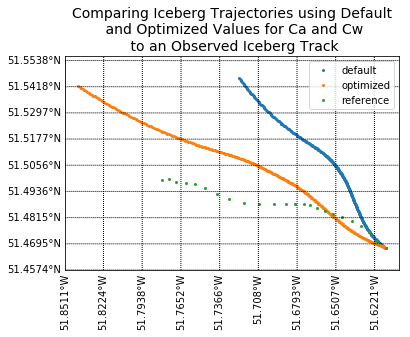

In [292]:
title = 'Comparing Iceberg Trajectories using Default\n and Optimized Values for Ca and Cw\n to an Observed Iceberg Track'
sizes = 4
legend_kwargs = {'loc': 1}
kwargs = {'title': title, 'sizes': sizes, 'legend_kwargs': legend_kwargs}
fig, ax = sim.results.plot(['default', 'optimized', 'reference'], labels=['default', 'optimized', 'reference'], 
                         **kwargs)
fig.savefig(plot_dir + 'tracks_from_default_and_optimized_Ca_and_Cw.png', bbox_inches='tight')

### Brute force

In [24]:
Ca_num = 16
Cw_num = 16
Ca_lower_bound = 0.1; Ca_upper_bound = 15
Cw_lower_bound = 0.1; Cw_upper_bound = 15

data_filename = data_dir + f'mses_for_Ca_{Ca_lower_bound}-{Ca_upper_bound}_and_Cw_{Cw_lower_bound}-{Cw_upper_bound}.npy'

try:
    mse_matrix = np.load(data_filename)

except FileNotFoundError:
    
    scaling = 'lin'

    if scaling == 'log':

        Ca_vec = np.logspace(np.log10(Ca_lower_bound), np.log10(Ca_upper_bound), num=Ca_num)
        Cw_vec = np.logspace(np.log10(Cw_lower_bound), np.log10(Cw_upper_bound), Cw_num=num)

    elif scaling == 'lin':

        Ca_vec = np.linspace(Ca_lower_bound, Ca_upper_bound, Ca_num)
        Cw_vec = np.linspace(Cw_lower_bound, Cw_upper_bound, Cw_num)


    Ca_mesh, Cw_mesh = np.meshgrid(Ca_vec, Cw_vec)

    mse_matrix = np.zeros((Ca_num, Cw_num))
    keys = ['Ca', 'Cw']
    reference_vectors = [tc.ref_lats, tc.ref_lons]

    for i in range(Ca_num):
        for j in range(Cw_num):
            form_drag_coefficients = (Ca_mesh[i][j], Cw_mesh[i][j])
            mse_matrix[i][j] = sim.optimization_wrapper(form_drag_coefficients, keys, reference_vectors)
            
    np.save(data_filename, mse_matrix)

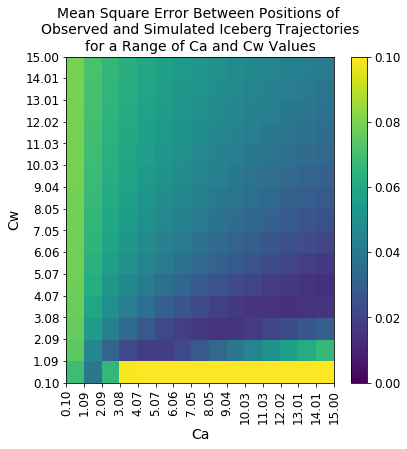

In [25]:
fig = plt.figure(figsize=(6,6))

plt.pcolormesh(Ca_vec, Cw_vec, mse_matrix, vmin=0, vmax=0.1)

plt.xticks(Ca_vec, rotation='vertical')
plt.yticks(Cw_vec)

plt.xlabel('Ca')
plt.ylabel('Cw')

plt.title('Mean Square Error Between Positions of \n'+ \
          'Observed and Simulated Iceberg Trajectories\n' + \
          'for a Range of Ca and Cw Values')

plt.colorbar()

plt.show()

fig.savefig(plot_dir + 'mse_color_plot.png', bbox_inches='tight')

# Distance Between Observed and Optimized Tracks

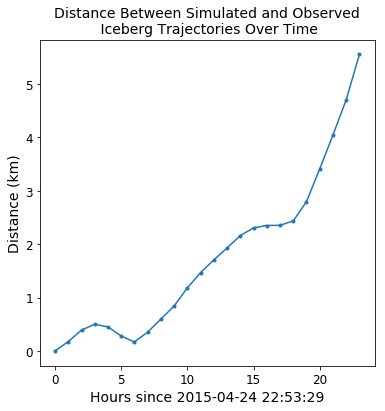

In [253]:
norms = sim.results.compute_distance_between_two_tracks('reference', 'optimized')
plt.plot(norms, '.-')
plt.ylabel('Distance (km)')
plt.xlabel('Hours since {}'.format(pd.Timestamp(tc.ref_times[0])))
plt.title('Distance Between Simulated and Observed\n Iceberg Trajectories Over Time')
plt.show()